In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import loggamma
from scipy.optimize import minimize

In [6]:

def get_neg_log_binomial_posterior(n_trial, n_success, alpha, beta):

    def neg_log_binomial_posterior(logit_p):
        p = np.exp(logit_p) / (1.0 + np.exp(logit_p))

        log_prior = loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta)
        log_prior += ((alpha-1.0) * np.log(p)) + ((beta-1.0) * np.log(1.0-p))

        log_likelihood = loggamma(n_trial + 1)
        log_likelihood -= loggamma(n_trial - n_success + 1.0)
        log_likelihood -= loggamma(n_success + 1.0)
        log_likelihood += (n_success * np.log(p))
        log_likelihood += ((n_trial - n_success) * np.log(1.0 - p))

        log_posterior = log_likelihood + log_prior

        return -log_posterior
    
    return neg_log_binomial_posterior

In [7]:
n_trial = 10
n_success = 5

alpha = 8
beta = 2

neg_log_posterior = get_neg_log_binomial_posterior(n_trial, n_success, alpha, beta)

p0 = float(n_success) / float(n_trial)
logit_p0 = np.log(p0 / (1.0 -p0))
x0 = np.array([logit_p0])


In [8]:
map_estimate = minimize(neg_log_posterior, x0, method='BFGS', options={'disp': True})

Optimization terminated successfully.
         Current function value: 1.651160
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 6


In [9]:
map_estimate

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.6511598227791526
        x: [ 6.931e-01]
      nit: 5
      jac: [ 2.980e-08]
 hess_inv: [[ 2.499e-01]]
     nfev: 12
     njev: 6

In [10]:
p_optimal = np.exp(map_estimate['x'][0])/ (1.0 + np.exp(map_estimate['x'][0]))
print("MAP estimate of success probability = ", p_optimal)

MAP estimate of success probability =  0.6666666638873496


In [11]:
def perform_mh_trial(x, log_post, delta_x, neg_log_posterior):
    accept_trial = False
    x_trial = x + (delta_x*(2.0*np.random.rand(1) - 1.0))
    p_trial = np.exp(x_trial)/(1.0 + np.exp(x_trial))
    
    # Calculate the log-posterior for the trial point.
    # Note we'll need to flip the sign of neg_log_posterior, as 
    # our callable returns the negative of the log-posterior.
    log_post_trial = -neg_log_posterior(x_trial) + np.log(p_trial*(1.0-p_trial))
    
    # Calculate the change in log-posterior if we move to the trial point
    delta_log_post = log_post_trial - log_post
        
    # Work out if should accept the trial point
    if delta_log_post > 0.0:
        accept_trial = True
    else:
        if np.log(np.random.rand(1)) < delta_log_post:
            accept_trial = True
            
    # If we accept the trial point then update the current value of the parameter and 
    # the log-posterior
    if accept_trial==True:
        x = x_trial
        log_post = log_post_trial
        
    return x, log_post

def mh_mcmc(n_burnin, n_iter, x0, delta_x, neg_log_posterior):
    x = x0
    p0 = np.exp(x0)/(1.0 + np.exp(x0))
    log_post = -neg_log_posterior(x) + np.log(p0*(1.0-p0))
    
    # Run the chain for the specified burn-in length
    for iter in range(n_burnin):
        x, log_post = perform_mh_trial(x, log_post, delta_x, neg_log_posterior)
        
    # Initialize an empty array to hold the sampled parameter values
    x_chain = np.zeros(n_iter)
    
    # Continue the chain for the specified number of sampling points
    # Store the sampled parameter values
    for iter in range(n_iter):
        x, log_post = perform_mh_trial(x, log_post, delta_x, neg_log_posterior)
        x_chain[iter] = x
        
    return x_chain

In [12]:
n_trial = 10
n_success = 5

alpha = 8
beta = 2

p0 = float(n_success) / float(n_trial)
logit_p0 = np.log(p0 / (1.0 -p0))

In [13]:
x_chain = mh_mcmc(n_burnin=20000, 
                  n_iter=1000000, 
                  x0=logit_p0, 
                  delta_x=0.1, 
                  neg_log_posterior=neg_log_posterior)

/tmp/ipykernel_4393/905240008.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_chain[iter] = x


In [14]:
p_mcmc = np.exp(x_chain)/ (1.0 + np.exp(x_chain))

In [15]:
def true_binomial_posterior(n_trial, n_success, alpha, beta, p):
    
    log_posterior = loggamma(n_trial + alpha + beta) - loggamma(n_success + alpha) - loggamma(n_trial - n_success + beta)
    log_posterior += ((n_success + alpha - 1.0)*np.log(p)) + ((n_trial-n_success + beta -1.0)*np.log(1.0-p))
    
    posterior = np.exp(log_posterior)
    
    return posterior

In [16]:
p_sequence = np.arange(0.01, 0.99, 0.005)
true_posterior_sequence = np.zeros(p_sequence.shape[0])

for i in range(true_posterior_sequence.shape[0]):
    true_posterior_sequence[i] = true_binomial_posterior(n_trial, n_success, alpha, beta, p_sequence[i])

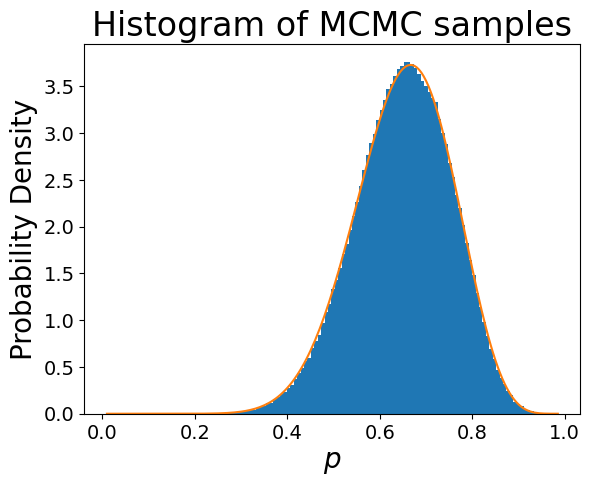

In [25]:
hist = plt.hist(p_mcmc, bins=100, density=True)
posterior = plt.plot(p_sequence, true_posterior_sequence)
plt.title('Histogram of MCMC samples', fontsize=24)
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()